<a href="https://colab.research.google.com/github/DanielMelo404/EEG_Markov_model/blob/main/HMM_GIGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install hidden_markov
!pip install pyhhmm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyhhmm: filename=pyhhmm-2.0.1-py3-none-any.whl size=35505 sha256=e865ad2fd7adecd3d8120916a33e88bbd8a73cd4d7f7c9f174ca165b5c9f7a0a
  Stored in directory: /root/.cache/pip/wheels/c9/18/07/4db05501458fe0f2267a2f9da0a62d811093ebad8baf06a4f4
Successfully built pyhhmm


In [2]:
import itertools as it
import scipy.spatial.distance as dis
from scipy import signal
import time 
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import resample
from joblib import Parallel, delayed
import pickle
from sklearn.metrics import pairwise_distances

In [ ]:
%%capture
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.databases.git
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.utils.git

import gcpds.databases as loaddb

In [ ]:
from gcpds.utils import colab
colab.mount()

In [ ]:
db = loaddb.GIGA_MI_ME()
fs = db.metadata['sampling_rate']
channels = db.metadata['channels']
print(channels)
print(db.metadata['classes'])
print(db.metadata['montage'])
print(fs)

Hacer la lista de sujetos para iterar sobre ella para armar los modelos de markov

In [ ]:
import numpy as np
X_ch10 = np.zeros((50,200,512*5))
list_sbjs = []#Lista para guardar tuplas (sujeto, arreglo de trials)
for i in range(50):
    db.load_subject(i+1) 
    print("sbj",i+1)
    if( i+1 != 29):
      run, class_ = db.get_data(classes=['left hand mi', 'right hand mi'])
      run_aux = run[:,10,512*2:512*7]       #Solo se toman los ultimos 5 segundos porque son los que tienen la informacion para clusterizar
      list_sbjs.append((i+1,run_aux[:,::10]))


In [ ]:
import pandas as pd
import seaborn as sns
sbj = 1
db.load_subject(sbj) 
run, class_ = db.get_data(classes=['left hand mi', 'right hand mi'])
run.shape, class_.shape

In [ ]:
run_ = run[:,:,::10]
run_.shape

### Hacer PCA para identificar clusters de sujetos (se debe correr por aparte, pues utiliza mucha RAM)


In [ ]:
for i in range(50):
    db.load_subject(sbj) 
    run, class_ = db.get_data(classes=['left hand mi', 'right hand mi'])
    run = run[:,:,::10]
    run_ = np.concatenate((run_,run),axis = 1)
    print(run_.shape)

In [ ]:
run__ = run_.reshape(200*3264,359)

In [ ]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
X_ = std.fit_transform(run__)
X_.shape

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
X = run__
pca = PCA(n_components=2)
# pca.fit(X)
PCA(n_components=2)
X_new = pca.fit_transform(X_)
X_new.shape
plt.figure(figsize  = (50,50))
plt.scatter(X_new[:,0],X_new[:,1])

#Ajustar HMMs

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def pretreatment(x):#Se estandariza la señal  de entrada 
  x= x.reshape(-1,1)
  # x = x[::10]
  minMax = MinMaxScaler()
  x =minMax.fit_transform(x)
  return x

def quantize(x):#Discretizar a la señal en ns+1 cuantos
  ns = 10
  q= 1/(ns)
  y = q * np.round(x/q)
  y = y*10
  return y

##Entrenamiento de HMM con Baum-Welch

In [ ]:
import pyhhmm.utils as ut
from pyhhmm.multinomial import MultinomialHMM

def makeMarkovModel(X,str_sbj):#Esta funcion entrena un modelo de markov para una secuencia X
                                #str_sbj es una string para guardar el archivo en el que 
    X = [i.astype(int) for i in X]
    n_states = [3]
    
    models_list = []
    AIC_list = []#Originalmente se escogeria el mejor AIC al entrenar modelos con n_states numero de estados
                #esta lista los almacena


    criteria = {'AIC': np.zeros_like(n_states), 'BIC': np.zeros_like(n_states)}
    for idx, ns in enumerate(n_states):
      
      trained_hmm = MultinomialHMM(
                    # number of hidden states 
                    n_states=ns,     
                    # number of discrete emissions 
                    n_emissions=1,
                    # length of the observation alphabet 
                    n_features=[11],
                    # type of initialisation to use; can be 'uniform' or 'random'
                    init_type='random'
                    )

      trained_hmm, log_likelihood = trained_hmm.train(
                    X,
                    n_init=1,     # no. of initialisations - we only do it once this time; if multiple initialisations are used, the model with the best log-likelihood will be returned
                    n_iter=100,   # maximum no. of iterations to use
                    conv_thresh=1e-4,   # convergence threshold (in this case if the change in consecutive log-likelihood is < 0.1%)
                    conv_iter=5,  # no. of iterations for which the convergence criteria should hold before stopping
                    plot_log_likelihood=True, # if we want a plot of the log-likelihood evolution over the iterations
                    )

      # compute the number of free parameters of the model
      dof = ut.get_n_fit_scalars(trained_hmm)

      # compute the model order selection criteria
      aic = ut.aic_hmm(log_likelihood, dof)
      criteria['AIC'][idx] = aic

      bic = 1#ut.bic_hmm(log_likelihood, n_samples, dof)
      #criteria['BIC'][idx] = bic
      models_list.append((trained_hmm,aic))
      print('{} states: logL = {:.3f}, AIC = {:.3f}, BIC = {:.3f}'.format(ns, log_likelihood, aic, bic))
      AIC_list.append(aic)
      import os
      if not(os.path.exists('modelos')):
        os.mkdir("modelos")

      with open('modelos/hmms_'+str_sbj, 'wb') as fp: #Exportar archivo en donde se guarda la lista de modelo que se tienen al momento 
        pickle.dump(models_list, fp)                  

      if aic == min(AIC_list):#Dado que n_states tenga mas de un elemento, escoger el modelo con mejor AIC
        best_hmm = trained_hmm  
      print(models_list)
    return models_list, best_hmm

In [ ]:
from pyhhmm.multinomial import MultinomialHMM
import os
def makeMarkovModelforChannel(sequences,str_sbj):#Rutina para obtener el modelo de markov para un canal
                                                  #sequences: lista de arreglos np de forma (n,1), con estos se enteran
                                                  #str_sbj: es la misma string para el nombre del archivo
  X = []
  for i in range(sequences.shape[0]):
      x = sequences[i,:]
      x = pretreatment(x)
      x = quantize(x)
      x=x.reshape(-1,1)                   #El framework pyhhmm exige esta forma
      X.append(x)
  return makeMarkovModel(X,str_sbj)

def make_markov_models_for_subject(run):  #Hacer el modl
    mm_list = []  
    for i in range(run.shape[1]):
      sequences = run[:,i,:]
      mm_list.append(makeMarkovModelforChannel(sequences))
    return mm_list

lista_hmms = []

#El siguiente ciclo for puede tomar dias en correr debido al entrenamiento de los hmms
for i in range(3,len(list_sbjs)):#Entrenar los modelos para todos los sujetso y guardarlos en lista_hmms
  i_ = i+1
  lista_modelos, best_model = makeMarkovModelforChannel(list_sbjs[i][1],'sbj'+str(i+1))
  lista_hmms.append((lista_modelos,best_model))

#Funciones para comparacion de HMMs

In [ ]:
from scipy.special import rel_entr

def gini(x):
    x = np.abs(x)
    """Compute Gini coefficient of array of values"""
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    # print(diffsum / (len(x)**2 * np.mean(x)))
    return diffsum / (len(x)**2 * np.mean(x))

def normalized_gini(x):
  N = np.max(x.shape[0])
  return N*gini(x)/(N-1)

def similarity(Q):
  sum_gini_rows = 0
  sum_gini_cols = 0
  n1 = Q.shape[0]
  n2 = Q.shape[1]
  for i in range(n1):
    # print(normalized_gini(Q[i,:]))
    sum_gini_rows += normalized_gini(Q[i,:])
  for j in range(n2):
    sum_gini_cols += normalized_gini(Q[:,j])
  return 0.5*(sum_gini_rows/n1+sum_gini_cols/n2)

def KLBstates(ps1,ps2):
  ps1 = ps1.tolist()
  ps2 = ps2.tolist()
  return sum(rel_entr(ps1,ps2))


def stationary_states(A):
  A_T = A.T
  n = A.shape[0]
  A_T[:,n-1] = np.ones((n,))
  A_T[0,0] = A_T[0,0]-1
  A_T[1,0] = A_T[1,0]-1
  b = np.zeros((n,1))
  b[b.size-1] = 1
  pi = np.linalg.inv(A).dot(b)
  return pi.T

def Qmatrix(A1,A2,B1,B2):
  n1 = A1.shape[0]
  n2 = A2.shape[0]
  stationary_1 = stationary_states(A1)
  stationary_2 =  stationary_states(A2)
  Q = np.zeros((n1,n2))
  for i in range(n1):
    for j in range(n2): 
      Q[i,j] =  stationary_1[0,i]*stationary_2[0,j]*KLBstates(B1[i,:],B2[j,:])
      ES =np.sum(Q)
  Q = Q/ES
  return Q


In [ ]:


def compute_adjacency_matrix(mm_list):#con base en la lista de modelos de markov, formar una matriz de adjacencia
                                      #esta representa un grafo con pesos
                                      #cada peso (entrada de la matriz) es la similaridad entre un modelo y otro
    adj_matrix = np.zeros((len(mm_list),len(mm_list)))
    for i in range(len(mm_list)):
        for j in range(len(mm_list)):
            mm_list[i]
            mm_list[j]
            A1 = mm_list[i]
            # extrarer As y Bs
            Q = Qmatrix(A1,A2,B1,B2);
            similarity(Q)

    return adj_matrix



#Hacer clusterizacion de los modelos encontrados

In [ ]:
from sklearn.cluster import KMeans

# our adjacency matrix
print("Adjacency Matrix:")
np.random.seed(0)
A = np.random.rand(50,50);  # A es la la matriz de adjacencia 
A = (A + A.T)/2

D = np.diag(A.sum(axis=1))

L = D-A

vals, vecs = np.linalg.eig(L)

vecs = vecs[:,np.argsort(vals)]
vals = vals[np.argsort(vals)]

kmeans = KMeans(n_clusters=4)
vecs = np.real(vecs)
kmeans.fit(vecs[:,1:4])
# print(vecs.shape)
colors = kmeans.labels_
print(kmeans)
print(colors)

import matplotlib as mpl
# from colorspacious import cspace_converter
plt.figure(figsize=(20,20))
_=plt.imshow(A,cmap='bwr')
plt.colorbar()

In [ ]:
from sklearn.neighbors import kneighbors_graph
from scipy import sparse


graph_laplacian_s = sparse.csgraph.laplacian(csgraph=adjacency_matrix_s, normed=False)
graph_laplacian = graph_laplacian_s.toarray()
 
    
graph_laplacian = generate_graph_laplacian(df=data_df, nn=8)

eigenvals_sorted_indices = np.argsort(eigenvals)
indices = eigenvals_sorted_indices[:num_ev]
k_means = KMeans(random_state=25, n_clusters=n_clusters)
k_means.fit(df)
cluster = k_means.predict(df)

eigenvals, eigenvcts = linalg.eig(graph_laplacian)

proj_df = pd.DataFrame(eigenvcts[:, indices.squeeze()])
proj_df.columns = ['v_' + str(c) for c in proj_df.columns]

#Algoritmo de Baum-Welch

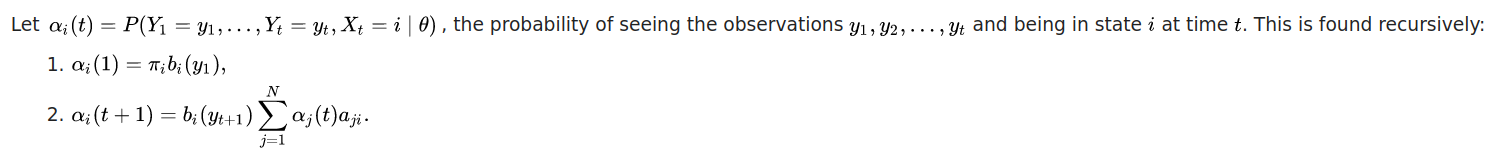

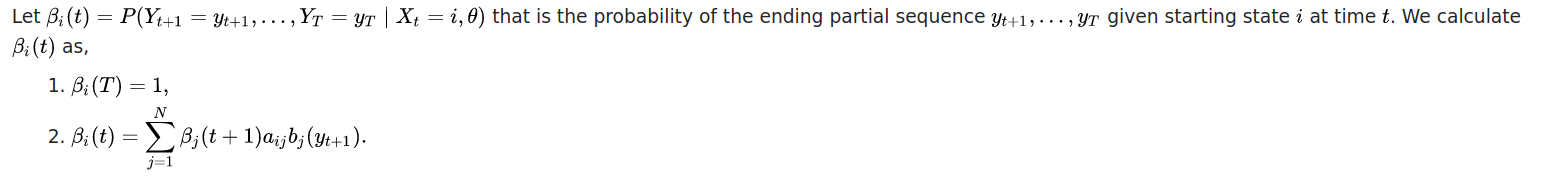

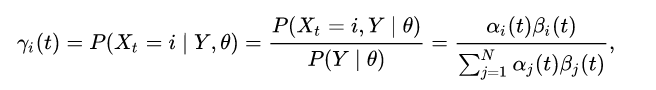

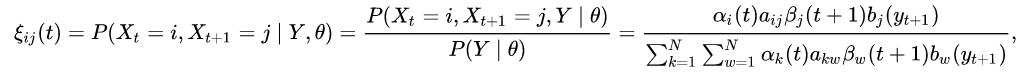

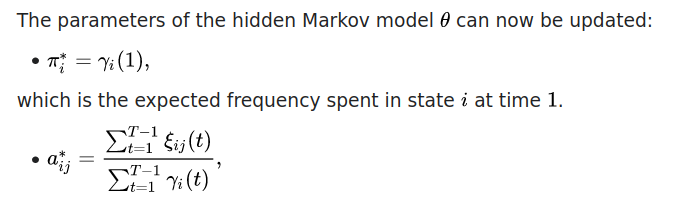

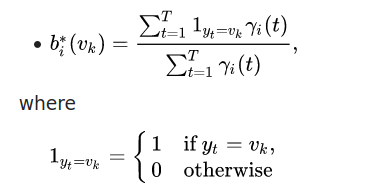

## Funciones y Procedimientos de `EEGv01b.ipyn`

Dividir un arreglo de [Trials, Canales, Tiempo] para cada clase y tomar un trial.

In [ ]:
tc1 = run[class_ == 0]
tc2 = run[class_ == 1]

twoclases = np.concatenate((tc1[0,:,1024:1536],tc2[0,:,1024:1536]),axis=0)

plt.figure(figsize=(24,16))
covMatrix = np.corrcoef(twoclases)
plt.imshow(np.abs(covMatrix[:64,64:]))
plt.yticks(range(0,64), channels)
plt.xticks(range(0,64), channels, rotation = "vertical")
plt.colorbar()

In [ ]:
def SumCovMatrix(covMatrix):
  newColumn = []
  for i in range(np.abs(covMatrix).shape[1]):
    newColumn.append(np.abs(covMatrix)[i,:].sum())

  newColumn = np.asarray(newColumn)
  newCovMatrix = np.concatenate((covMatrix, np.expand_dims(newColumn, axis=1)), axis=1)
  #print(covMatrix.shape, np.expand_dims(newColumn,axis=1).shape, newCovMatrix.shape)
  return newCovMatrix

In [ ]:
newCovMatrix = SumCovMatrix(covMatrix[:64,64:])

plt.figure(figsize=(16,8))
plt.imshow(np.abs(newCovMatrix))
plt.colorbar()

In [ ]:
def SortMatrixbyRow(matrix, row):
  unsortedRow = matrix[:,row]
  sorted_matrix = np.zeros_like(matrix)
  index = np.arange(0,64,1)
  new_index = np.zeros_like(index)
  for i in range(len(unsortedRow)):
    for j in range(len(unsortedRow)):
      if matrix[j,-1] == np.sort(unsortedRow)[i]:
        sorted_matrix[i,:] = matrix[matrix[:,-1] == np.sort(unsortedRow)[i]]
        new_index[i] = index[matrix[:,-1] == np.sort(unsortedRow)[i]]
  return sorted_matrix, new_index

In [ ]:
sortedCovMatrix, index = SortMatrixbyRow(newCovMatrix, -1)

In [ ]:
np.array(channels*2)[index[::-1]]

In [ ]:
plt.figure(figsize=(16,12))
plt.imshow(np.abs(sortedCovMatrix[:,:-1][::-1]))
plt.yticks(range(64), labels = np.array(channels)[index[::-1]]);
plt.xticks(range(64), channels, rotation="vertical");

In [ ]:
sorted_channels = np.array(channels*2)[index[::-1]]

plt.figure(figsize=(20,12))
plt.plot(sortedCovMatrix[:,-1][::-1])
plt.xticks(range(0,64), sorted_channels, rotation='vertical');

# funciones

In [ ]:
def sliding_window(data, window, overlap):
    """"""
    return np.array([data[start:start + window] for start in range(0, len(data) - (window - int(np.ceil(window * (1 - overlap)))), int(np.ceil(window * (1 - overlap))))], dtype=object)

In [ ]:
def gauss_kernel(X):
    d = dis.cdist(X,X)
    sigma = np.median(d)
    K = np.exp(-((d)**2)/(2*sigma**2))
    return K
    
def kernel_entropy(A,alpha=2):
    #A = A/np.trace(A)
    H = np.real((1/(1-alpha))*np.log2(np.trace(np.asmatrix(A)**alpha)))
    return H

def joint_kernel_entropy(A,B, alpha=2):
    Kj = (A*B)/np.trace(A*B)
    JKE = kernel_entropy(Kj, alpha)
    return JKE

In [ ]:
def kernel_marginal_entropy_window(X):
  etropy_vec = []
  kernels = []
  for i in range(X.shape[0]):
    kernel = gauss_kernel(X[i].reshape(-1,1))  
    kernels.append(kernel)
    etropy_vec.append(kernel_entropy(kernel/np.trace(kernel)))
    
  return etropy_vec, kernels

def kernel_mutual_information_window(Marginal1 , Marginal2, kernel1, kernel2 ):
  etropy_vec = []
  for i in range(Marginal1.shape[0]):
    join = joint_kernel_entropy(kernel1[i], kernel2[i])
    etropy_vec.append(Marginal1[i] + Marginal2[i] -join )
  return np.array(etropy_vec)

In [ ]:
new_fs = 256
def winddowandentropy(X, win=int(0.5*new_fs), over=0.8):
  X_windowed = sliding_window(X, win, over)
  Xentropy, kernels = kernel_marginal_entropy_window(X_windowed)
  return np.float32(Xentropy), np.float32(np.array(kernels))


In [ ]:
def mutual_information_perchannels(path_kernels, sujeto, tri):
  path = path_kernels
  with open(path_kernels+'sujeto'+str(sujeto)+'resting_parte'+str(tri)+'.pickle', "rb") as f:
    X = pickle.load(f)   
  entropy_array = np.zeros((len(X), len(X), X[0][0].shape[0]))
  #X must the object with kernels and marginal entropy 
  for chan1 in range(len(X)):
    #print('channel nº: ', chan1+1)
    for chan2 in range(chan1, len(X)):
      mutual = kernel_mutual_information_window(X[chan1][0], X[chan2][0], X[chan1][1], X[chan2][1])
      entropy_array[chan1,chan2] = mutual
      entropy_array[chan2, chan1] = mutual
  return entropy_array

# Nmarginal and kernels

In [ ]:
path_save_marginal_andKernels = '/content/drive/MyDrive/entropias_algoritmos/entropies_giga/entropias_marginales_kernels/'
new_fs = 256

In [ ]:
fs/2

In [ ]:
#  [2,7,8,11,12,16,17,18,20,32,33,38,40,44,52] 
for sub in [52, 20]:#Subjects:, 14 , 41, 2,23,7
  print('sub:',sub)
  start = time.time()    
  db.load_subject(sub) 
  trials, class_ = db.get_data(classes=['left hand mi', 'right hand mi'])
  n_trials = trials.shape[0]
  print(trials.shape) 
  # trials = trials[:,:,int(2.5*fs)::]
  # print(trials.shape)
  trials = resample(trials,int(new_fs*trials.shape[2]/fs),axis=-1)
  print(trials.shape)

  for tri in range(trials.shape[0]):
    start = time.time()
    print('trial Nº: ', tri+1 )
    y = Parallel(n_jobs=-1)(delayed(winddowandentropy)(trials[tri,ch,:]) for ch in range(trials.shape[1]))
    #y[canales(19)][0 = H marginal y 1 = kernel(500*500)] esto me da un array de 91 marginales o de (91, 500, 500) kernels
    print(y[0][1].shape, )
    with open(path_save_marginal_andKernels+'sujeto'+str(sub)+'resting_parte'+str(tri)+'.pickle', "wb") as f:
      pickle.dump(y, f)
  print('time:' + str(time.time()-start) + ' seg.' )

In [ ]:
trials, class_ = db.get_data(classes=['left hand mi', 'right hand mi'])
trials = resample(trials,int(new_fs*trials.shape[2]/fs),axis=-1)

trials

In [ ]:
sliding_window(trials,int(0.5*new_fs), 0.8).shape

In [ ]:
# 21 min por sujeto 

In [ ]:
Subjects = [2,32,33,38,40,44,52]
for sub in [41]: #Subjects:#Subjects: 
  print('sujeto: ', sub)
  #-------------------------------
  db.load_subject(sub) 
  run, class_ = db.get_data(classes=['left hand mi', 'right hand mi'])
  n_trials = run.shape[0]
  #-------------------------------

  start = time.time()   
  MI_array = np.array(Parallel(n_jobs=-1)(delayed(mutual_information_perchannels)(path_save_marginal_andKernels, sub, tri) for tri in range(n_trials)) )
  with open(path_save_marginal_andKernels+'MI_tensor_sujeto'+str(sub)+'.pickle', "wb") as f:
    pickle.dump(MI_array, f)
  print('  time: ', time.time()-start, ' seg.')


In [ ]:
with open(path_save_marginal_andKernels+'MI_tensor_sujeto'+str(sub)+'.pickle', "wb") as f:
    pickle.dump(MI_array, f)

In [ ]:
#ordenes de canales 
canales_p_o = ['Fp1', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Oz', 'POz', 'Pz', 'CPz', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']
ch_p_o_id = []
for i in range(len(canales_p_o)):
  ch_p_o_id.append(channels.index(canales_p_o[i]))

canales_c = ['FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz' , 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6',  'CP6', 'CP4', 'CP2' ]
ch_c_id = []
for i in range(len(canales_c)):
  ch_c_id.append(channels.index(canales_c[i]))

ch_ORDER_f = np.array([1,33,34,2,3,37,36,35,7,6,5,4,38,39,40,41,42,8,9,10,11,47,46,45,44,43,15,14,13,12,48,49,50,51,52,16,17,18,19,32,56,55,54,53,24,23,22,21,20,31,57,58,59,60,61,25,26,30,63,62,27,29,64,28])-1




In [ ]:

n_trials = 200
#entro_sujetos= np.zeros((22 , n_trials, 19, 91)) #[sujetos, trials, canales, ventanas]

for sub in [3]:#Subjects:[2,32,33,38,40,44,52]  
  #-----------------
  db.load_subject(sub) 
  run, class_ = db.get_data(classes=['left hand mi', 'right hand mi'])
  n_trials = run.shape[0]
  #----------------
  with open(path_save_marginal_andKernels+'MI_tensor_sujeto'+str(sub)+'.pickle', "rb") as f:
    MI_array = pickle.load(f) 

In [ ]:
MI_array.shape

In [ ]:
A = np.arange(0,int(1792/new_fs),1/new_fs )
A_window = sliding_window(A,int(0.5*new_fs), 0.8)
print(A_window.shape)
print(np.where(A_window[:,0]==2.5390625))
print(np.where(A_window[:,0]==4.5703125))

In [ ]:
def inertia_(X):
   D = pairwise_distances(X, X.mean(axis=0).reshape(1,-1))
   inertia_ = D.mean()
   return inertia_

In [ ]:

n_trials = 200
#entro_sujetos= np.zeros((22 , n_trials, 19, 91)) #[sujetos, trials, canales, ventanas]

for sub in [2,23,7, 3, 14, 41]:
  #-----------------
  db.load_subject(sub) 
  run, class_ = db.get_data(classes=['left hand mi', 'right hand mi'])
  n_trials = run.shape[0]
  #----------------
  with open(path_save_marginal_andKernels+'MI_tensor_sujeto'+str(sub)+'.pickle', "rb") as f:
    MI_array = pickle.load(f)[:,:,:,25:45]
  traials_productopunto = []

  
  traials_productopunto = []
  for tri in range(MI_array.shape[0]):
    #producto_punto =[]
    producto_punto = np.zeros((MI_array.shape[1],MI_array.shape[2]))
    for chan1 in range(MI_array.shape[1]):
        #print('channel nº: ', chan1+1)
        c1 = MI_array[tri,chan1,chan1,:]
        c1_vec = []
        for chan2 in range(chan1, MI_array.shape[1]):
          c2 = MI_array[tri,chan1,chan2,:]
          dot = np.dot(c1, c2)
          producto_punto[chan1, chan2] = dot
          producto_punto[chan2, chan1] = dot           
        #producto_punto.append(np.mean(c1_vec))
    traials_productopunto.append(np.mean(producto_punto, axis = 1))

  print(len(traials_productopunto))

  traials_productopunto_kernel = np.array(traials_productopunto)
  plt.figure(figsize=(17,7))
  plt.ylim([0,10])
  iner = inertia_(traials_productopunto_kernel)
  plt.title('Mutual Information resting state - kernel entropy sujeto '+str(sub)+ ' inertia ' + str(iner))
  for i in range(len(traials_productopunto_kernel)):
    #plt.plot(channels, traials_productopunto_kernel[i], label='trial '+str(i+1))
    plt.plot(np.array(channels)[ch_ORDER_f], traials_productopunto_kernel[i,ch_ORDER_f])
  plt.legend()
  plt.show()

In [ ]:
n_trials = 200
#entro_sujetos= np.zeros((22 , n_trials, 19, 91)) #[sujetos, trials, canales, ventanas]

for sub in [3, 14, 41]:#Subjects:[2,32,33,38,40,44,52]  
  #-----------------
  db.load_subject(sub) 
  run, class_ = db.get_data(classes=['left hand mi', 'right hand mi'])
  n_trials = run.shape[0]
  #----------------
  with open(path_save_marginal_andKernels+'MI_tensor_sujeto'+str(sub)+'.pickle', "rb") as f:
    MI_array = pickle.load(f)[:,:,:,25:45] 
  traials_productopunto = []

  
  traials_productopunto = []
  for tri in range(MI_array.shape[0]):
    #producto_punto =[]
    producto_punto = np.zeros((MI_array.shape[1],MI_array.shape[2]))
    for chan1 in range(MI_array.shape[1]):
        #print('channel nº: ', chan1+1)
        c1 = MI_array[tri,chan1,chan1,:]
        c1_vec = []
        for chan2 in range(chan1, MI_array.shape[1]):
          c2 = MI_array[tri,chan1,chan2,:]
          dot = np.dot(c1, c2)
          producto_punto[chan1, chan2] = dot
          producto_punto[chan2, chan1] = dot           
        #producto_punto.append(np.mean(c1_vec))
    traials_productopunto.append(np.mean(producto_punto, axis = 1))

  traials_productopunto_kernel = np.array(traials_productopunto)
  plt.figure(figsize=(17,7))
  plt.ylim([0,10])
  plt.title('Mutual Information resting state - kernel entropy sujeto '+str(sub))
  for i in range(len(traials_productopunto_kernel)):
    #plt.plot(channels, traials_productopunto_kernel[i], label='trial '+str(i+1))
    plt.plot(np.array(channels)[ch_ORDER_f], traials_productopunto_kernel[i,ch_ORDER_f])
  plt.legend()
  plt.show()

## Gaussian Regressor

### Example

In [ ]:
class0 = tc1[:,:,1024:1536]
class1 = tc2[:,:,1024:1536]

print(class0.shape, class1.shape)

In [ ]:
input = class0[0,52,:]
output = class1[0,0,:]

(input.shape, output.shape)

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(random_state=0).fit(input.reshape(1,-1), output.reshape(1,-1))
gpr.score(input.reshape(1,-1), output.reshape(1,-1))

In [ ]:
prediction = gpr.predict(input.reshape(1,-1))

In [ ]:
plt.figure(figsize = (16,9))
plt.plot(prediction.reshape(-1), label = "Prediction", linestyle='dashed')
plt.plot(output, label = f"Channel {channels[0]}", alpha= 0.5);

In [ ]:
correlation_matrix = np.corrcoef(class0[0], prediction)

correlation_xy = correlation_matrix[0,1]

r_squared = correlation_xy**2


print(r_squared)

### Every channel as input vs every channel as output

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow import keras

#### Class for calculating functional connectivity using a Gaussian Regressor.

In [ ]:
class ConnectivityRegressor():

  def __init__ (self, regressor, input, output):

    # Constructor, receives the name of the regressor, the input data and the output.
    self.regressor = regressor
    self.input = input
    self.output = output
    self.model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1,activation='linear')
    ])
    self.regressors = {"Gaussian": GaussianProcessRegressor,
                       "NN": self.model} #Dictionary of regressors
     
  def MultipleChannelRegression(self): # genero una matriz 
    
    # Regression using an input of (trials, channel, time). Where is used every trial of a single channel of one class as input and every trial of the other class used as output.
    
    predictions_matrix = np.zeros((self.input.shape[0], self.input.shape[2])) #Matrix to save predictions 
    r_squared_matrix = np.zeros((self.input.shape[1], self.input.shape[1])) #Matrix to save r2 of every channel

    if self.regressor == "Gaussian":
      for i in range(self.input.shape[1]):
        for j in range(self.input.shape[1]):
          self.regressor_model = self.regressors[self.regressor](random_state=0) 
          print(f"Starting training for channel {i} {channels[i]} as input and channel {j} {channels[j]} as output...")
          self.regressor_model.fit(self.input[:,i,:], self.output[:,j,:])

          #random_trial_prediction = np.random.randint(self.input.shape[1])
          
          for p in range(self.input.shape[1]):
            if p !=0 and self.input.shape[1] % p != 0:
              print(f"Starting prediction for channel {channels[p]}...")
            prediction = self.regressor_model.predict(self.input[p,:,:])
            predictions_matrix[p] = prediction[p]
          
          random_number = np.random.randint(self.input.shape[1])
        
          r_squared_matrix[i,j] = r2_score(self.output[random_number,i,:], predictions_matrix[random_number,:])

    if self.regressor == "NN":
      for i in range(self.input.shape[1]):
        for j in range(self.input.shape[1]):
          self.regressors[self.regressor].compile(loss="mse", optimizer="adam")
          history = self.regressors[self.regressor].fit(self.input[:,i,:], output[:,j,:], epochs=50)
          prediction = self.regressors[self.regressor].predict(self.input)

          r_squared_matrix[i,j] = r2_score(self.output, prediction)
        
    return r_squared_matrix

In [ ]:
cr = ConnectivityRegressor("Gaussian", class0, class1)
rsquared = cr.MultipleChannelRegression()

In [ ]:
plt.figure(figsize=(16,12))
plt.imshow(rsquared)
plt.colorbar()
plt.yticks(range(64), channels);
plt.xticks(range(64), channels, rotation="vertical");

In [ ]:
def GaussianRegressorForMultipleChannels(Input, Output):
  r_squared_matrix = np.zeros((Input.shape[0], Input.shape[0]))
  mae_matrix = np.zeros((Input.shape[0], Input.shape[0]))
  for i in range(Input.shape[0]):
    for j in range(Input.shape[0]):
    
      gpr = GaussianProcessRegressor(random_state=0)
      gpr.fit(Input[i].reshape(1,-1), Output[j].reshape(1,-1))

      prediction = gpr.predict(Input[i].reshape(1,-1))

      correlation_matrix = np.corrcoef(Input[i], prediction)
      correlation_xy = correlation_matrix[0,1]

      r_squared = correlation_xy**2
      r_squared_matrix[i,j] = r_squared
                
      Mae = mae(Output[j].reshape(1,-1), prediction)
      mae_matrix[i,j] = Mae

  return r_squared_matrix, mae_matrix

In [ ]:
rSquaredMatrix, maeMatrix = GaussianRegressorForMultipleChannels(class0,class1)

### Matrix $r^2$

In [ ]:
plt.figure(figsize=(16,12))
plt.imshow(rSquaredMatrix)
plt.colorbar()
plt.yticks(range(64), channels);
plt.xticks(range(64), channels, rotation="vertical");

### Correlation Matrix

In [ ]:
plt.figure(figsize=(16,12))
plt.imshow(np.abs(covMatrix[:64,64:]))
plt.colorbar()
plt.yticks(range(64), channels);
plt.xticks(range(64), channels, rotation="vertical");

## Functional connectivities

In [ ]:
FILEID = "1fdP0ijDn1f41Ez-PQIvr4X1RXnszVQj3"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O codigos.zip && rm -rf /tmp/cookies.txt
!unzip codigos.zip
!dir

In [ ]:
%cd MI_EEG_ClassMeth/
from FeatExtraction import Phase_based_Connectivities  

In [ ]:
def PLV(X):
  PLV_M = np.zeros((X.shape[0], int(0.5*X.shape[1]*(X.shape[1]-1))))
  for trial in range(X.shape[0]):
    PLV_ = Phase_based_Connectivities()._phase_locking_value(X = X[trial,:,1024:1536])
    PLV_M[trial] = PLV_
  return PLV_M

In [ ]:
PLV = PLV(run)

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(PLV)
plt.colorbar()

In [ ]:
Save a copy in GitHub